In [9]:
# IMPORT MODULES

import sklearn
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [10]:
# LOAD DATA

data_file ='features.csv'
print(f'reading from {data_file}')
df = pd.read_csv(data_file, index_col=0)

df = df[df['MeanP']>60]  # there is an outlier to remove with MeanP around 50


df['Gender'] = df['Gender'].astype('category')  # for any non-numeric column, make sure you set it to a category if its going to be used as a predictor or target
df = pd.get_dummies(df)  # will one-hot encode categories.  Note gender turns into 2 columns (M or F), with a boolean value for each

print(df)


# get the names of the targets (output variables) and prdictors (input variables)
targets = df.columns[0:3].to_list()
print(f'targets: {targets}')
predictors = df.columns[3:].to_list()
print(f'predictors: {predictors}')


reading from features.csv
     MeanP  DiastolicP  SystolicP  Age  Height  Weight  area_falling_0.7  \
0    131.8        88.9      190.9   61   149.0    51.8         97.808876   
1    129.2        94.7      172.7   68   155.1    61.3         86.315120   
2    129.1        93.7      175.8   68   155.1    61.3         90.950990   
3    127.8        98.2      176.8   45   167.0    83.0        102.851870   
4    125.6        81.4      192.5   74   160.0    66.2         96.219780   
..     ...         ...        ...  ...     ...     ...               ...   
188   79.2        63.4      110.9   59   158.0    77.7         77.089580   
189   79.0        63.5      102.7   48   165.0    73.7         75.050780   
190   75.7        56.0      112.3   83   163.0    57.5         73.172935   
191   75.6        61.5       99.8   52   167.0    67.0         56.797020   
192   75.5        59.5      109.8   68   167.0    77.7         61.348625   

     area_rising_0.7  amplitude_falling_0.7  amplitude_rising

In [11]:
# when you look at this dataframe, there should only be numeric (or boolean) data now
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 192
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MeanP                      193 non-null    float64
 1   DiastolicP                 193 non-null    float64
 2   SystolicP                  193 non-null    float64
 3   Age                        193 non-null    int64  
 4   Height                     193 non-null    float64
 5   Weight                     193 non-null    float64
 6   area_falling_0.7           193 non-null    float64
 7   area_rising_0.7            193 non-null    float64
 8   amplitude_falling_0.7      193 non-null    float64
 9   amplitude_rising_0.7       193 non-null    float64
 10  area_falling_0.5           193 non-null    float64
 11  area_rising_0.5            193 non-null    float64
 12  amplitude_falling_0.5      193 non-null    float64
 13  amplitude_rising_0.5       193 non-null    float64
 14 

In [12]:
# NORMALIZE THE DATA

scaler_predictors = MinMaxScaler()
X = scaler_predictors.fit_transform(df[predictors])

scaler_targets = MinMaxScaler()
Y = scaler_targets.fit_transform(df[targets])

print(X.shape, np.max(X), np.min(X))
print(Y.shape, np.max(Y), np.min(Y))


(193, 19) 1.0000000000000004 0.0
(193, 3) 1.0 0.0


In [13]:
# SPLIT INTO TRAIN AND TEST

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print(f'x_train: (samples, features) = {x_train.shape}')
print(f'x_test: (samples, features) = {x_test.shape}')
print(f'y_train: (samples, features) = {y_train.shape}')
print(f'y_test: (samples, features) = {y_test.shape}')


x_train: (samples, features) = (154, 19)
x_test: (samples, features) = (39, 19)
y_train: (samples, features) = (154, 3)
y_test: (samples, features) = (39, 3)


In [14]:
# FIT THE MODEL

from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(x_train, y_train)

y_predict_train = model.predict(x_train)
y_predict_test = model.predict(x_test)


In [15]:
# undo normalization
x_train_unnormalized = scaler_predictors.inverse_transform(x_train)
x_test_unnormalized = scaler_predictors.inverse_transform(x_test)

y_predict_train_unnormalized = scaler_targets.inverse_transform(y_predict_train)
y_predict_test_unnormalized = scaler_targets.inverse_transform(y_predict_test)

y_actual_train_unnormalized = scaler_targets.inverse_transform(y_train)
y_actual_test_unnormalized = scaler_targets.inverse_transform(y_test)

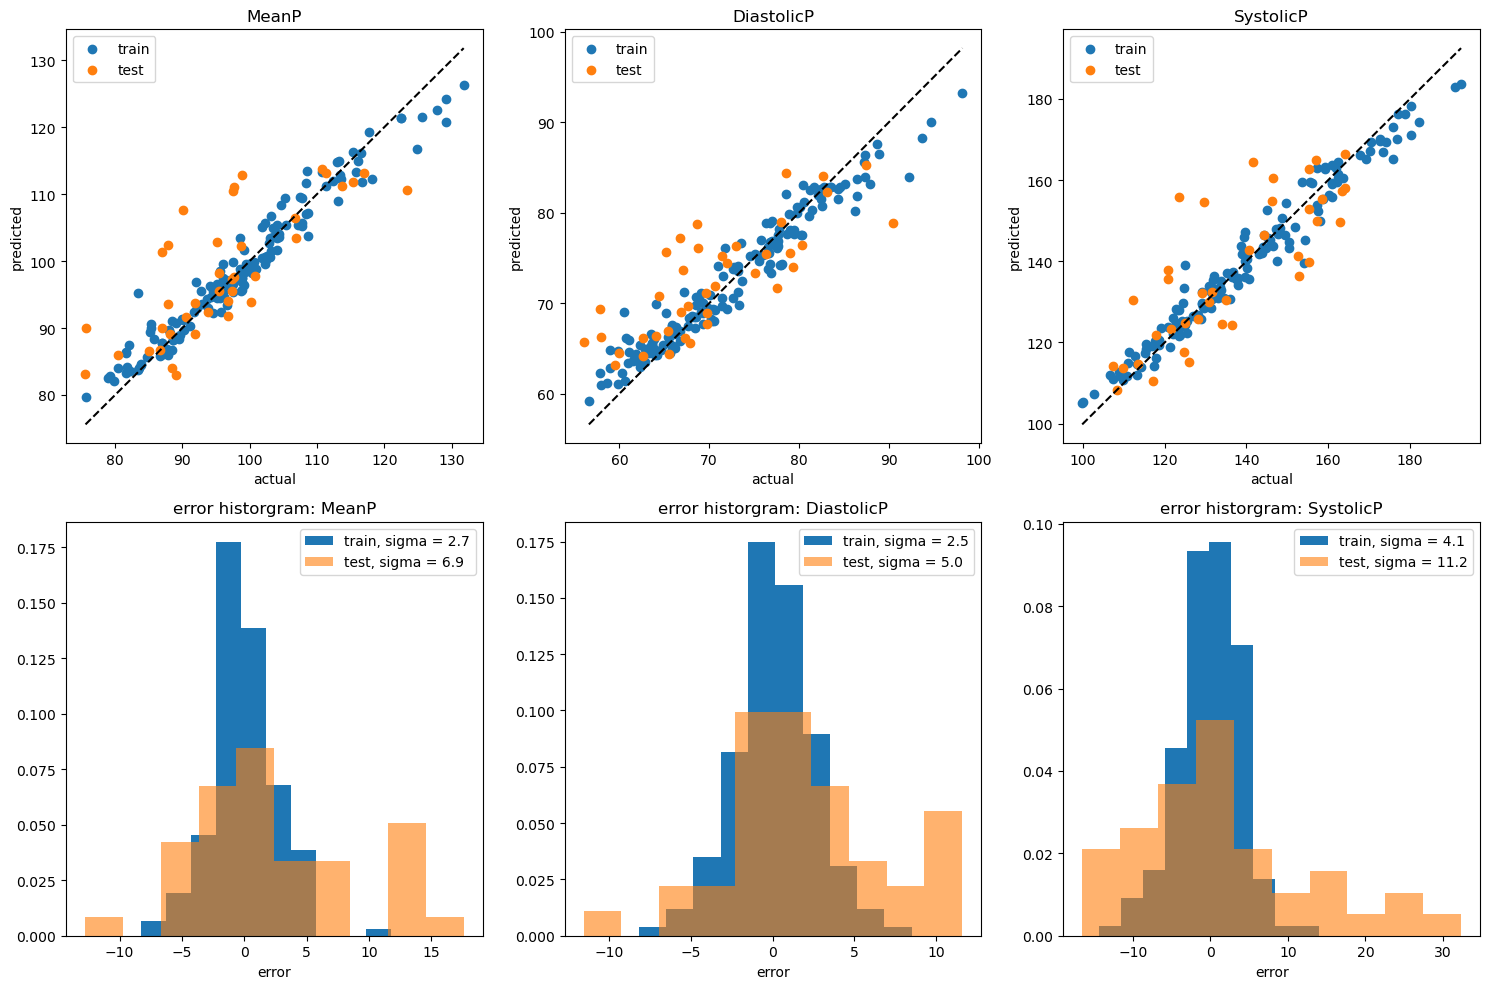

In [16]:
# PLOTTING

N_targets = len(targets)

fig, ax = plt.subplots(2, N_targets)
fig.set_size_inches(15, 10)

for i in range(N_targets):

    ax[0,i].scatter(y_actual_train_unnormalized[:, i], y_predict_train_unnormalized[:, i], label = 'train')
    ax[0,i].scatter(y_actual_test_unnormalized[:, i], y_predict_test_unnormalized[:, i], label = 'test')
    ax[0,i].set_xlabel('actual')
    ax[0,i].set_ylabel('predicted')
    ax[0,i].set_title(targets[i])
    ax[0,i].legend()

    ymin = np.min([*y_actual_train_unnormalized[:, i], *y_predict_train_unnormalized[:, i]])
    ymax = np.max([*y_actual_train_unnormalized[:, i], *y_predict_train_unnormalized[:, i]])
    ax[0,i].plot([ymin, ymax], [ymin, ymax], color = 'k', linestyle = '--')

    error_train =  y_predict_train_unnormalized[:, i] - y_actual_train_unnormalized[:, i]
    error_test =  y_predict_test_unnormalized[:, i] - y_actual_test_unnormalized[:, i]
    std_error_train = np.std(error_train)
    std_error_test = np.std(error_test)

    ax[1,i].hist(error_train, label = f'train, sigma = {std_error_train:.1f}', density = True, alpha = 1)
    ax[1,i].hist(error_test, label = f'test, sigma = {std_error_test:.1f}', density = True, alpha = .6)
    ax[1,i].set_xlabel('error')
    ax[1,i].set_title(f'error historgram: {targets[i]}')
    ax[1,i].legend()

fig.tight_layout()